<a href="https://colab.research.google.com/github/CLAIR-LAB-TECHNION/energy-net/blob/main/notebooks/Running_the_day_ahead_market_cycle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Managing the Day-Ahead Market

electricity-market.svg

The objective of this tutorial is to demonstrate the process of running the day-ahead market. The setting we consider here includes two types of agents: the ISO, which sets the electricity production plan and the sell and feed-in tariffs, and the PCS units (production, consumption, and storage units) that participate in the market.

❗ Importantly, the PCSunit is a general entity that may be associated with various production, consumption, and storage functions (or only one of them). This means that it can be instantiated in many ways to represent, for example, a battery (only storage), a household (with all three capabilities), or a city (with any relevant combination of the three). This generalization is a software engineering concept that allows us to create code that is varsetile and adaptable.

## Decision-Operational Cycle:


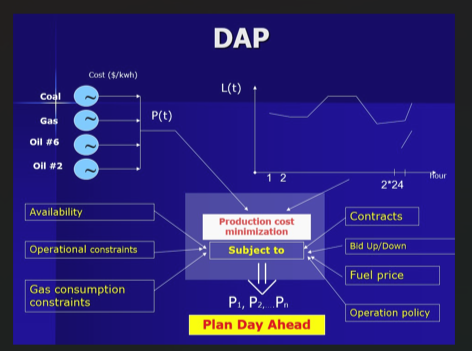

As a first step, we deal with the day-ahead market under the assumption that all the information is known and all the decisions are made at time 0. We will later relax these assumptions.  


We are considering a 24-hour decision horizon of 48 half-hour intervals.

The input includes:
- the predicted demand $\hat{D}$ for each timestep (interval) in the decision horizon
- the production capabilities and costs of the units controlled by the ISO for each timestep (and its controlled units)
- the production, storage, and transmission bounds on each PCSUnit






The iterative process includes at every iteration (every 24 hours at timestep 0):
- the ISO sets the Day-Ahead Program (DAP) that sets the amount of electricity to produce at each timestep
- the ISO sets the sell and feed-in tariffs per timestep for the entire decision horizon
- the PCSUnits see the prices and decide how much power to store, sell/buy, and consume at every timestep. In practice, all these are often reflected by one decision variable that considers storage.

This process continues until convergence or until resources are exhausted (whatever is first and in any case before timestep 1)

## Assumptions (for now):

*  All decisions are made at time 0. This means that the policies are fixed at time 0 and while an  agent can choose its current action based on the real-time state at any timestep t, the policy (mapping from states of actions) is fixed at timestep 0, i.e., there is no real-time update of policies
* As a first step, we assume that the predicted and realized demands are equal
* The DAP process is abstracted, i.e., we do not deal with how the generation is distributed among controlled production agents. We only deal with the high-level decision of how much to generate and the pricing of energy
* For now, the demand is modeled as a sinusoidal for which the user sets the parameters. Later on, we will integrate more elaborate ways to define demand
* Similarly, the production costs are fixed (per unit and per timestep). This too will be extended to support elaborate functions   



#The `energy-net` Environment

As a reminder, `energy-net` is a package we are developing for smart grid simulation, designed to model and simulate energy dynamics in a network of interconnected entities.


This is the repo's link [https://github.com/CLAIR-LAB-TECHNION/energy-net](https://github.com/CLAIR-LAB-TECHNION/energy-net)

##Step 1: Setting Up the `energy-net` Environment

First, we setup the` energynet ` environment by installing it. No need to do anything beyond running the cell.

In [2]:
!git clone https://github.com/CLAIR-LAB-TECHNION/energy-net.git

%cd energy-net
!pip install -e .

Cloning into 'energy-net'...
remote: Enumerating objects: 4273, done.
remote: Counting objects: 100% (488/488), done.
remote: Compressing objects: 100% (294/294), done.
remote: Total 4273 (delta 207), reused 383 (delta 184), pack-reused 3785 (from 1)
Receiving objects: 100% (4273/4273), 866.82 MiB | 25.01 MiB/s, done.
Resolving deltas: 100% (1688/1688), done.
/content/energy-net
Obtaining file:///content/energy-net
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 847.8/847.8 kB 27.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.3/77.3 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 28.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.1/91.

In [3]:
## add to requirements later !
!pip install ruamel.yaml


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.7/117.7 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 739.1/739.1 kB 34.5 MB/s eta 0:00:00


# Setting up a simulation

While you run the notebook, you will be required to configure some values. When this is required, a text box appears below the cell and execution will pose until the values are set. For example:

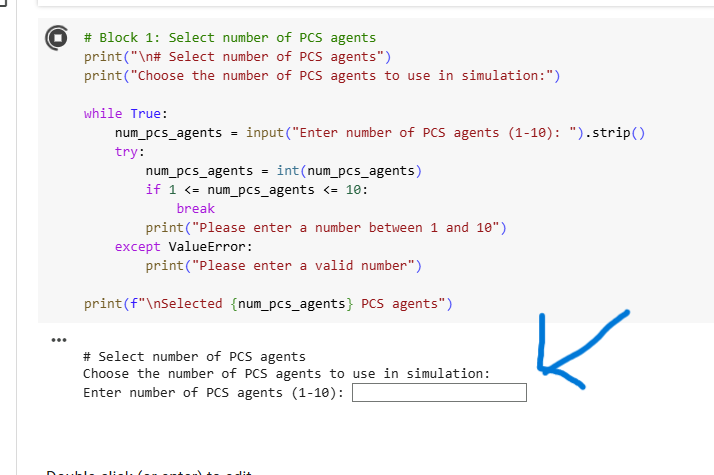

Note that because we are using a notebook, we are using pre-trained agents. This means that the policies that will be run do not adapt to the specific parameters that are set and may exhibit sub-optimal performance. To get the actual results, you need to run the code using the appropriate computing power.

## Step 1: Selecting a Pricing Mechanism


First, we select the pricing mechanism that will be used for the simulation.

We are considering four options:
- INTERVALS: two price levels per day in response to demand level
- QUADRATIC: quadratic (sublinear) prices for purchasing (selling) power from (to) the ISO
- ONLINE: prices are set in response to market signals. This option is currently not active but will be implemented later on
- RANDOM: a random assignment of prices

In [ ]:
print("Select a pricing mechanism (this will be used as a constant parameter):")
print("1: INTERVALS   (two price levels in response to demand level)")
print("2: QUADRATIC   (quadratic/sublinear prices for power purchase/sale)")
print("3: ONLINE      (currently inactive, to be implemented)")
print("4: RANDOM      (random pricing)")

# Save the selected pricing mechanism in a global variable
pricing_choice = input("Enter 1, 2, 3, or 4: ").strip()

if pricing_choice == "1":
    pricing_mechanism = "INTERVALS"
elif pricing_choice == "2":
    pricing_mechanism = "QUADRATIC"
elif pricing_choice == "3":
    pricing_mechanism = "ONLINE"
elif pricing_choice == "4":
    pricing_mechanism = "RANDOM"
else:
    print("Invalid input; defaulting to QUADRATIC")
    pricing_mechanism = "QUADRATIC"

print(f"Selected pricing mechanism: {pricing_mechanism}")

## Step 2: Selecting a Demand Pattern

Here, we select the pattern of the expected demand. This will be used to set the daily dispatch.

In [17]:
print("\n# Select Demand Pattern")
print("Choose a demand pattern for the simulation:")
print("1: SINUSOIDAL  (smooth daily cycle with one peak)")
print("2: CONSTANT    (fixed demand level)")
print("3: DOUBLE_PEAK (morning and evening peaks)")

while True:
    demand_choice = input("Enter 1, 2, or 3: ").strip()

    if demand_choice == "1":
        demand_pattern = "SINUSOIDAL"
        break
    elif demand_choice == "2":
        demand_pattern = "CONSTANT"
        break
    elif demand_choice == "3":
        demand_pattern = "DOUBLE_PEAK"
        break
    else:
        print("Invalid input; please enter 1, 2, or 3")

print(f"\nSelected demand pattern: {demand_pattern}")


# Select Demand Pattern
Choose a demand pattern for the simulation:
1: SINUSOIDAL  (smooth daily cycle with one peak)
2: CONSTANT    (fixed demand level)
3: DOUBLE_PEAK (morning and evening peaks)
Enter 1, 2, or 3: 1

Selected demand pattern: SINUSOIDAL


## Step 3: Selecting and loading the PCS units (and their associated marktet players) and setting their paramaters


First, we select the number of PCS units

In [ ]:
# Block 1: Select number of PCS agents
print("\n# Select number of PCS agents")
print("Choose the number of PCS agents to use in simulation:")

while True:
    num_pcs_agents = input("Enter number of PCS agents (1-10): ").strip()
    try:
        num_pcs_agents = int(num_pcs_agents)
        if 1 <= num_pcs_agents <= 10:
            break
        print("Please enter a number between 1 and 10")
    except ValueError:
        print("Please enter a valid number")

print(f"\nSelected {num_pcs_agents} PCS agents")


# Select number of PCS agents
Choose the number of PCS agents to use in simulation:


We now load onf of the pre-trained agents that were trained using the different pricing models. While the agent (and policy) will be shared, we can later set the internal parameters of each PCS unit if we want (e.g., storage capacity).

For running the notebook, we have pre-trained 4 pcsunit agents:


1.  INTERVALS: two price levels in response to demand level
2.  QUADRATIC: quadratic (sublinear) prices for purchasing (selling) power from (to) the ISO
3.  ONLINE: currently not active: will be implemented later on
4. RANDOM: a random

Note that these correspond to the pricing approaches that can be chosen above.

In [ ]:
if pricing_mechanism = "INTERVALS":
    pcs_agent_config_path = "configs/pcs_agent_intervals.json"
elif pricing_mechanism = "QUADRATIC":
    pcs_agent_config_path = "configs/pcs_agent_quadratic.json"
elif  pricing_mechanism = "ONLINE":
    pcs_agent_config_path = "configs/pcs_agent_online.json"
elif pricing_mechanism = "RANDOM":
    pcs_agent_config_path = "configs/pcs_agent_random.json"
else:
    print("Invalid input; defaulting to QUADRATIC")
    pricing_mechanism = "QUADRATIC"
    pcs_agent_config_path = "configs/pcs_agent_quadratic.json"



Load the PCS agent (the trained policy that will be shared by the PCS units)

In [16]:
# Load the corresponding PCS agent configuration
def load_pcs_agent(config_path):
    # Replace this placeholder with our actual PCS agent loading function
    return f"Loaded PCS agent from {config_path}"

pcs_agent = load_pcs_agent(pcs_agent_config_path)
print("PCS Agent loaded:", pcs_agent)


PCS Agent loaded: Loaded PCS agent from configs/pcs_agent_quadratic.json


**TODO MATAN - what is this and what is the difference bewteen the cost and the pricing ?**

In [18]:
# Block: Select Cost Type

print("Select cost type:")
print("1: CONSTANT")
print("2: FUNCTION")
cost_type_choice = input("Enter 1 or 2: ").strip()

if cost_type_choice == "1":
    cost_type_str = "CONSTANT"
elif cost_type_choice == "2":
    cost_type_str = "FUNCTION"
else:
    print("Invalid choice. Defaulting to CONSTANT.")
    cost_type_str = "CONSTANT"


Select cost type:
1: CONSTANT
2: FUNCTION
Enter 1 or 2: 1


### Update PCS Battery Parameters

We now set the characteristics of the PCS units. For now, we only set the storage parameters.




In [20]:
#Configure PCS Agents Battery Parameters
from ruamel.yaml import YAML
import os

print("\n# Configure PCS Agents")
configs_path = os.path.join("configs", "pcs_configs.yaml")
yaml_obj = YAML()
yaml_obj.preserve_quotes = True

# Load or create config file
try:
    with open(configs_path, "r") as file:
        all_configs = yaml_obj.load(file)
except Exception as e:
    print(f"Creating new config file: {e}")
    all_configs = {}

# Configure each agent
editable_params = [
    "charge_efficiency",
    "charge_rate_max",
    "discharge_efficiency",
    "discharge_rate_max",
    "init",
    "max"
]

for agent_idx in range(num_pcs_agents):
    agent_key = f"pcs_{agent_idx + 1}"
    print(f"\nConfiguring {agent_key}:")

    # Create default config if doesn't exist
    if agent_key not in all_configs:
        all_configs[agent_key] = {
            "battery": {
                "dynamic_type": "model_based",
                "model_parameters": {
                    "charge_efficiency": 0.9,
                    "charge_rate_max": 9.0,
                    "discharge_efficiency": 0.9,
                    "discharge_rate_max": 9.0,
                    "init": 9.0,
                    "max": 99.0
                }
            }
        }

    # Show and edit battery parameters
    battery_params = all_configs[agent_key]["battery"]["model_parameters"]
    print("\nCurrent battery parameters:")
    for param in editable_params:
        print(f"{param}: {battery_params.get(param)}")

    # Ask to edit
    edit_choice = input(f"\nDo you want to edit battery parameters for {agent_key}? (yes/no): ").strip().lower()
    if edit_choice == "yes":
        for param in editable_params:
            current = battery_params[param]
            new_value = input(f"Enter new {param} (current={current}): ").strip()
            if new_value:  # Only update if user entered a value
                battery_params[param] = float(new_value)


# Configure PCS Agents

Configuring pcs_1:

Current battery parameters:
charge_efficiency: 0.9
charge_rate_max: 9.0
discharge_efficiency: 0.9
discharge_rate_max: 9.0
init: 9.0
max: 99.0

Do you want to edit battery parameters for pcs_1? (yes/no): מם


Afer setting the paremeters, we now update the values

In [21]:
# Block: Add Fixed Parameters
for agent_key in all_configs:
    # Add fixed battery parameters
    battery_params = all_configs[agent_key]["battery"]["model_parameters"]
    battery_params.update({
        "lifetime_constant": 100.0,
        "min": 0.0,
        "model_type": "deterministic_battery"
    })

    # Add consumption unit with fixed parameters
    all_configs[agent_key]["consumption_unit"] = {
        "dynamic_type": "model_based",
        "model_type": "deterministic_consumption",
        "model_parameters": {
            "consumption_capacity": 0.0,
            "peak_consumption1": 0.0,
            "peak_consumption2": 0.0,
            "peak_time1": 0.4,
            "peak_time2": 0.7,
            "width1": 0.05,
            "width2": 0.1
        }
    }

    # Add production unit with fixed parameters
    all_configs[agent_key]["production_unit"] = {
        "dynamic_type": "model_based",
        "model_type": "deterministic_production",
        "model_parameters": {
            "peak_production": 0.0,
            "peak_time": 0.5,
            "production_capacity": 0.0,
            "width": 0.1
        }
    }



All PCS configurations saved successfully.


Save complete configuration


In [ ]:
try:
    with open(configs_path, "w") as file:
        yaml_obj.dump(all_configs, file)
    print("\nAll PCS configurations saved successfully.")
except Exception as e:
    print(f"Error saving configurations: {e}")

## Step 3: ISO Setup


In this simulation, the ISO is the agent that is trained. We now set up its training parameters.

In [ ]:
print("\n--- ISO Training Parameter Setup ---")

**Todo Matan: what is the difference between itrations and episodes.  **

In [ ]:
try:
    total_iterations = int(input("Enter total iterations (e.g., 10): ").strip())
except:
    total_iterations = 10


In [ ]:

try:
    train_timesteps_per_iteration = int(input("Enter timesteps per iteration (e.g., 10000): ").strip())
except:
    train_timesteps_per_iteration = 10000


In [19]:
try:
    eval_episodes = int(input("Enter number of evaluation episodes (e.g., 5): ").strip())
except:
    eval_episodes = 5



--- ISO Training Parameter Setup ---
Enter total iterations (e.g., 10): 2
Enter timesteps per iteration (e.g., 10000): 10
Enter number of evaluation episodes (e.g., 5): 5
ISO Training will use the pricing mechanism: QUADRATIC


In [ ]:
# The pricing mechanism selected above will be used as a constant parameter for the ISO environment.
print(f"ISO Training will use the pricing mechanism: {pricing_mechanism}")

# Save ISO parameters to a dictionary for later use
iso_params = {
    "total_iterations": total_iterations,
    "train_timesteps_per_iteration": train_timesteps_per_iteration,
    "eval_episodes": eval_episodes,
    "pricing_mechanism": pricing_mechanism
}


# Running a simulation: Training the ISO

In [22]:
# Block 4: Training
print("\nStarting training...")

from iso_game_main import train_and_evaluate_agent, PricingPolicy
from energy_net.dynamics.iso.demand_patterns import DemandPattern
import random
from energy_net.dynamics.iso.cost_types import CostType


# Map the selected pricing mechanism to the corresponding PricingPolicy Enum value:
if pricing_mechanism == "QUADRATIC":
    pricing_policy_enum = PricingPolicy.QUADRATIC
elif pricing_mechanism == "INTERVALS":
    pricing_policy_enum = PricingPolicy.INTERVALS
elif pricing_mechanism == "ONLINE":
    pricing_policy_enum = PricingPolicy.ONLINE
elif pricing_mechanism == "RANDOM":
    pricing_policy_enum = PricingPolicy.RANDOM
else:
    pricing_policy_enum = PricingPolicy.QUADRATIC

# Convert the selected demand pattern to enum
demand_pattern_enum = DemandPattern[demand_pattern]

# Convert the selected cost type to enum
cost_type_enum = CostType[cost_type_str]

# select a seed
seed = random.randint(0, 10000)

# run the training phase
train_and_evaluate_agent(
    algo_type='PPO',
    num_pcs_agents=num_pcs_agents,
    cost_type=cost_type_enum,
    trained_pcs_model_path=pcs_agent,
    pricing_policy=pricing_policy_enum,
    demand_pattern=demand_pattern_enum,
    total_iterations=iso_params["total_iterations"],
    train_timesteps_per_iteration=iso_params["train_timesteps_per_iteration"],
    eval_episodes=iso_params["eval_episodes"],
    seed=seed
)


Starting training...


/usr/local/lib/python3.11/dist-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/usr/local/lib/python3.11/dist-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Output()

Starting iterative training for 2 iterations.
Training ISO, using current ISO model


Runtime info saved to runtime_info.pkl

[ISO] Mean Reward: -3465045.81 +/- 36252885.66
Saved flows and prices plot to logs/agent_iso/episode_0_flows_prices.png
Saved cost components plot to logs/agent_iso/episode_0_cost_components.png


Output()

Saved final cost distribution plot to logs/agent_iso/episode_0_final_cost_distribution.png
Training ISO, using current ISO model


Runtime info saved to runtime_info.pkl

[ISO] Mean Reward: -3462592.74 +/- 36252993.85
Saved flows and prices plot to logs/agent_iso/episode_1_flows_prices.png
Saved cost components plot to logs/agent_iso/episode_1_cost_components.png
Saved final cost distribution plot to logs/agent_iso/episode_1_final_cost_distribution.png
Iterative training completed.
Final ISO model saved to models/agent_iso/agent_iso_final.zip
Training and evaluation process completed.


/usr/local/lib/python3.11/dist-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/usr/local/lib/python3.11/dist-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Final ISO Model - Mean Reward: -19550167.095493697 +/- 42875550.52895628


# Evaluation

After the ISO agent finishes its training process, we evaluate its performance

First, we import some libraries

In [ ]:
import subprocess
import os
from IPython.display import Image, display


We load the trained ISO agent

In [ ]:
print("----- Evaluation / Visualizations -----")

trained_model_path = "models/agent_iso/agent_iso_final.zip"           # Final ISO model path
normalizer_path = "models/agent_iso/agent_iso_normalizer.pkl"           # Normalizer path
trained_pcs_model_path = "None"


We set the number of evaluation episodes

In [ ]:
eval_episodes = iso_params.get("eval_episodes", 5)
user_input = input(f"Enter number of evaluation episodes (default {eval_episodes}): ").strip()
if user_input:
    try:
        eval_episodes = int(user_input)
    except Exception as e:
        print("Invalid input; using default value.")


Now we run the evaluation process

In [23]:

print(f"Running evaluation using pricing mechanism: {pricing_mechanism}")
print(f"Evaluation parameters:")
print(f"  Normalizer: {normalizer_path}")
print(f"  Trained PCS model: {trained_pcs_model_path}")
print(f"  Evaluation episodes: {eval_episodes}")

command = [
    "python3", "eval_agent.py",

    "--trained_pcs_model_path", trained_pcs_model_path,
    "--normalizer_path", normalizer_path,
    "--pricing_policy", pricing_mechanism,
    "--demand_pattern", demand_pattern,
    "--cost_type", cost_type_str,
    "--trained_model_path", trained_model_path,
    "--eval_episodes", str(eval_episodes)
]



print("\nRunning evaluation with command:")
print(" ".join(command))
result = subprocess.run(command, capture_output=True, text=True)

print("\nEvaluation Output:")
print(result.stdout)
if result.stderr:
    print("Evaluation Errors:")
    print(result.stderr)


----- Evaluation / Visualizations -----
Enter number of evaluation episodes (default 5): 5
Running evaluation using pricing mechanism: QUADRATIC
Evaluation parameters:
  Normalizer: models/agent_iso/agent_iso_normalizer.pkl
  Trained PCS model: None
  Evaluation episodes: 5

Running evaluation with command:
python3 eval_agent.py --trained_pcs_model_path None --normalizer_path models/agent_iso/agent_iso_normalizer.pkl --pricing_policy QUADRATIC --demand_pattern SINUSOIDAL --cost_type CONSTANT --trained_model_path models/agent_iso/agent_iso_final.zip --eval_episodes 5

Evaluation Output:
Registering PCSUnitEnv-v0
Registering ISOEnv-v0

Starting Episode 1/5
Episode 1 completed - Reward: -1057701.06
Saved flows and prices plot to evaluation_results/episode_0_flows_prices.png
Saved cost components plot to evaluation_results/episode_0_cost_components.png
Saved final cost distribution plot to evaluation_results/episode_0_final_cost_distribution.png

Starting Episode 2/5
Episode 2 completed - 

# Visualization of results

We first import the needed libraries

In [ ]:
import pickle
import matplotlib.pyplot as plt


We load the data that was collected

In [ ]:
# Load runtime info (a list of episodes, each being a list of step dictionaries)
data_file = "runtime_info.pkl"
with open(data_file, "rb") as f:
    all_episodes_actions = pickle.load(f)


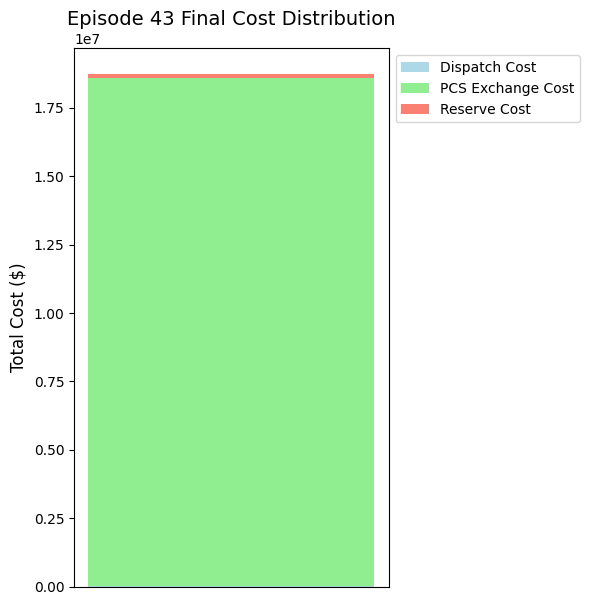

In [24]:
episode_number = random.randint(1, len(all_episodes_actions)) # maybe should change

if len(all_episodes_actions) < episode_number:
    print(f"Only {len(all_episodes_actions)} episodes available; cannot display episode {episode_number}.")
else:
    episode_data = all_episodes_actions[episode_number - 1]

    # Compute cost components as in your callbacks:
    dispatch_costs = [step.get('dispatch_cost', 0.0) for step in episode_data]
    pcs_costs = [
        step.get('net_exchange', 0.0) *
        (step.get('iso_sell_price', 0.0) if step.get('net_exchange', 0.0) > 0
         else step.get('iso_buy_price', 0.0))
        for step in episode_data
    ]
    reserve_costs = [step.get('reserve_cost', 0.0) for step in episode_data]

    total_dispatch = sum(dispatch_costs)
    total_pcs = sum(pcs_costs)
    total_reserve = sum(reserve_costs)

    # Create the final cost distribution figure (similar to Figure 3 in your callback)
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(1, 1, 1)

    ax.bar([0], [total_dispatch], color='lightblue', label='Dispatch Cost')
    ax.bar([0], [total_pcs], bottom=[total_dispatch], color='lightgreen', label='PCS Exchange Cost')
    ax.bar([0], [total_reserve], bottom=[total_dispatch + total_pcs], color='salmon', label='Reserve Cost')

    ax.set_ylabel('Total Cost ($)', fontsize=12)
    ax.set_title(f'Episode {episode_number} Final Cost Distribution', fontsize=14)
    ax.set_xticks([])
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=10)

    plt.tight_layout()
    plt.show()


Loaded runtime data with 84 episodes.


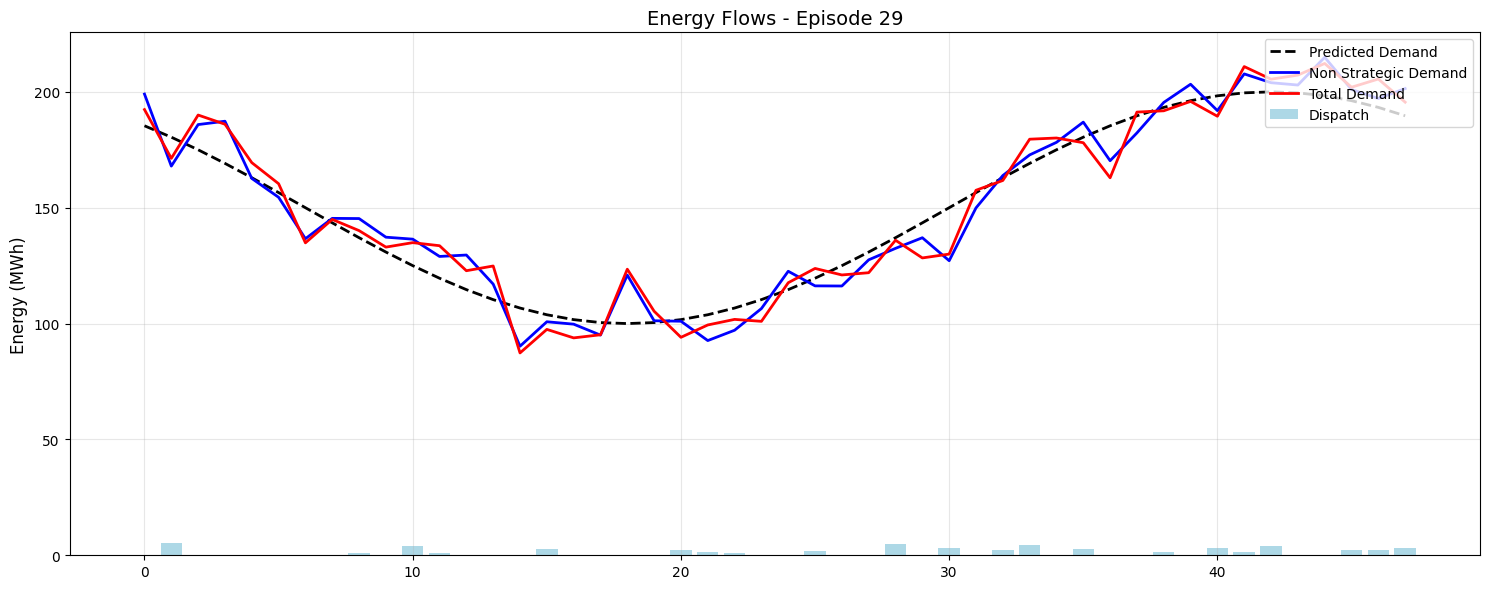

In [25]:
import pickle
import matplotlib.pyplot as plt

# Load runtime data from file (this file should have been created by your callback)
runtime_file = "runtime_info.pkl"
try:
    with open(runtime_file, "rb") as f:
        all_episodes_actions = pickle.load(f)
    print(f"Loaded runtime data with {len(all_episodes_actions)} episodes.")
except Exception as e:
    print("Error loading runtime data:", e)
    all_episodes_actions = []

# Define the episode number to plot (Episode 9)
episode_num = random.randint(1, len(all_episodes_actions))


if len(all_episodes_actions) < episode_num:
    print(f"Only {len(all_episodes_actions)} episodes available; cannot plot episode {episode_num}.")
else:
    episode_data = all_episodes_actions[episode_num - 1]

    # Extract data from the episode
    steps = [step.get('step', 0) for step in episode_data]
    dispatch = [step.get('dispatch', 0.0) for step in episode_data]
    predicted_demand = [step.get('predicted_demand', 0.0) for step in episode_data]
    realized_demand = [step.get('realized_demand', 0.0) for step in episode_data]
    net_exchange = [step.get('net_exchange', 0.0) for step in episode_data]

    # Compute total (net) demand: realized_demand + net_exchange
    net_demand = [r + n for r, n in zip(realized_demand, net_exchange)]

    # Create the plot replicating the upper graph ("Energy Flows")
    plt.figure(figsize=(15, 6))
    plt.bar(steps, dispatch, width=0.8, color='lightblue', label='Dispatch')
    plt.plot(steps, predicted_demand, 'k--', linewidth=2, label='Predicted Demand')
    plt.plot(steps, realized_demand, 'b-', linewidth=2, label='Non Strategic Demand')
    plt.plot(steps, net_demand, 'r-', linewidth=2, label='Total Demand')

    plt.ylabel('Energy (MWh)', fontsize=12)
    plt.title(f'Energy Flows - Episode {episode_num}', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.legend(loc='upper right', fontsize=10)
    plt.tight_layout()
    plt.show()


In [ ]:
#TODO graph Itay
# cost bar chart ,demand X t  X 10


In [ ]:
#TODO graph - dispatch Matan
# power gen policy

In [ ]:
#TODO graph Itay
# predicted demand

In [ ]:
#TODO graph throughout training Itay
# cost

In [ ]:
#TODO eval